# DS-210: Programming for Data Science


# Lecture 24: Cross-Validation and Parallel Programming


## Terminology

**Parameters**
* Variables fixed in a specific instantiation of a model
* Examples:
  * coefficients in linear regression
  * decision tree structure and thresholds
  * weights and thresholds in a neural network


**Hyperparameters**
* Also parameters, but higher level


* Examples:
  * number of leafs in a decision tree
  * number of layers and their structure in a neural network
  * degree of a polynomial


**Hyperparameter tuning**
* Adjusting hyperparameters before training the final model


**Model selection**
* Deciding on the type of model to be used (linear regression? decision trees? ...)



## Decision Tree discussion

* Tree structure and thresholds for splits are parameters (learned by the algorithm)  
* Many of the others are hyperparameters
 * split_quality: Sets the metric used to decide the feature on which to split a node
 * min_impurity_decrease: How much reduction in gini or other metric should we see before we allow a split 
 * min_weight_split: Sets the minimum weight of samples required to split a node.  
 * min_weight_leaf: Sets the minimum weight of samples that a split has to place in each leaf 
 * max_depth: Affects the structure of the tree and how elements can be assigned to nodes
 
 All documented at great length in (https://docs.rs/linfa-trees/latest/linfa_trees/struct.DecisionTreeParams.html)


## Challenges of training and cross-validation

**Big goal:** train a model that can be used for predicting

**Intermediate goal:** select the right model and hyperparameters

<div align="center">
    <b>How about trying various options and seeing how they perform on the test set?</b>
</div>

<div align="center">

</div>

**Information leak danger!**

* If we do it adaptively, information from the test set could affect the model selection

<div align="center">
    <h2><b>Cross–validation</b> attempts to solve this problem </h2>
</div>

Tune your parameters by using portions of the training set and preserve the test set for only a final evaluation

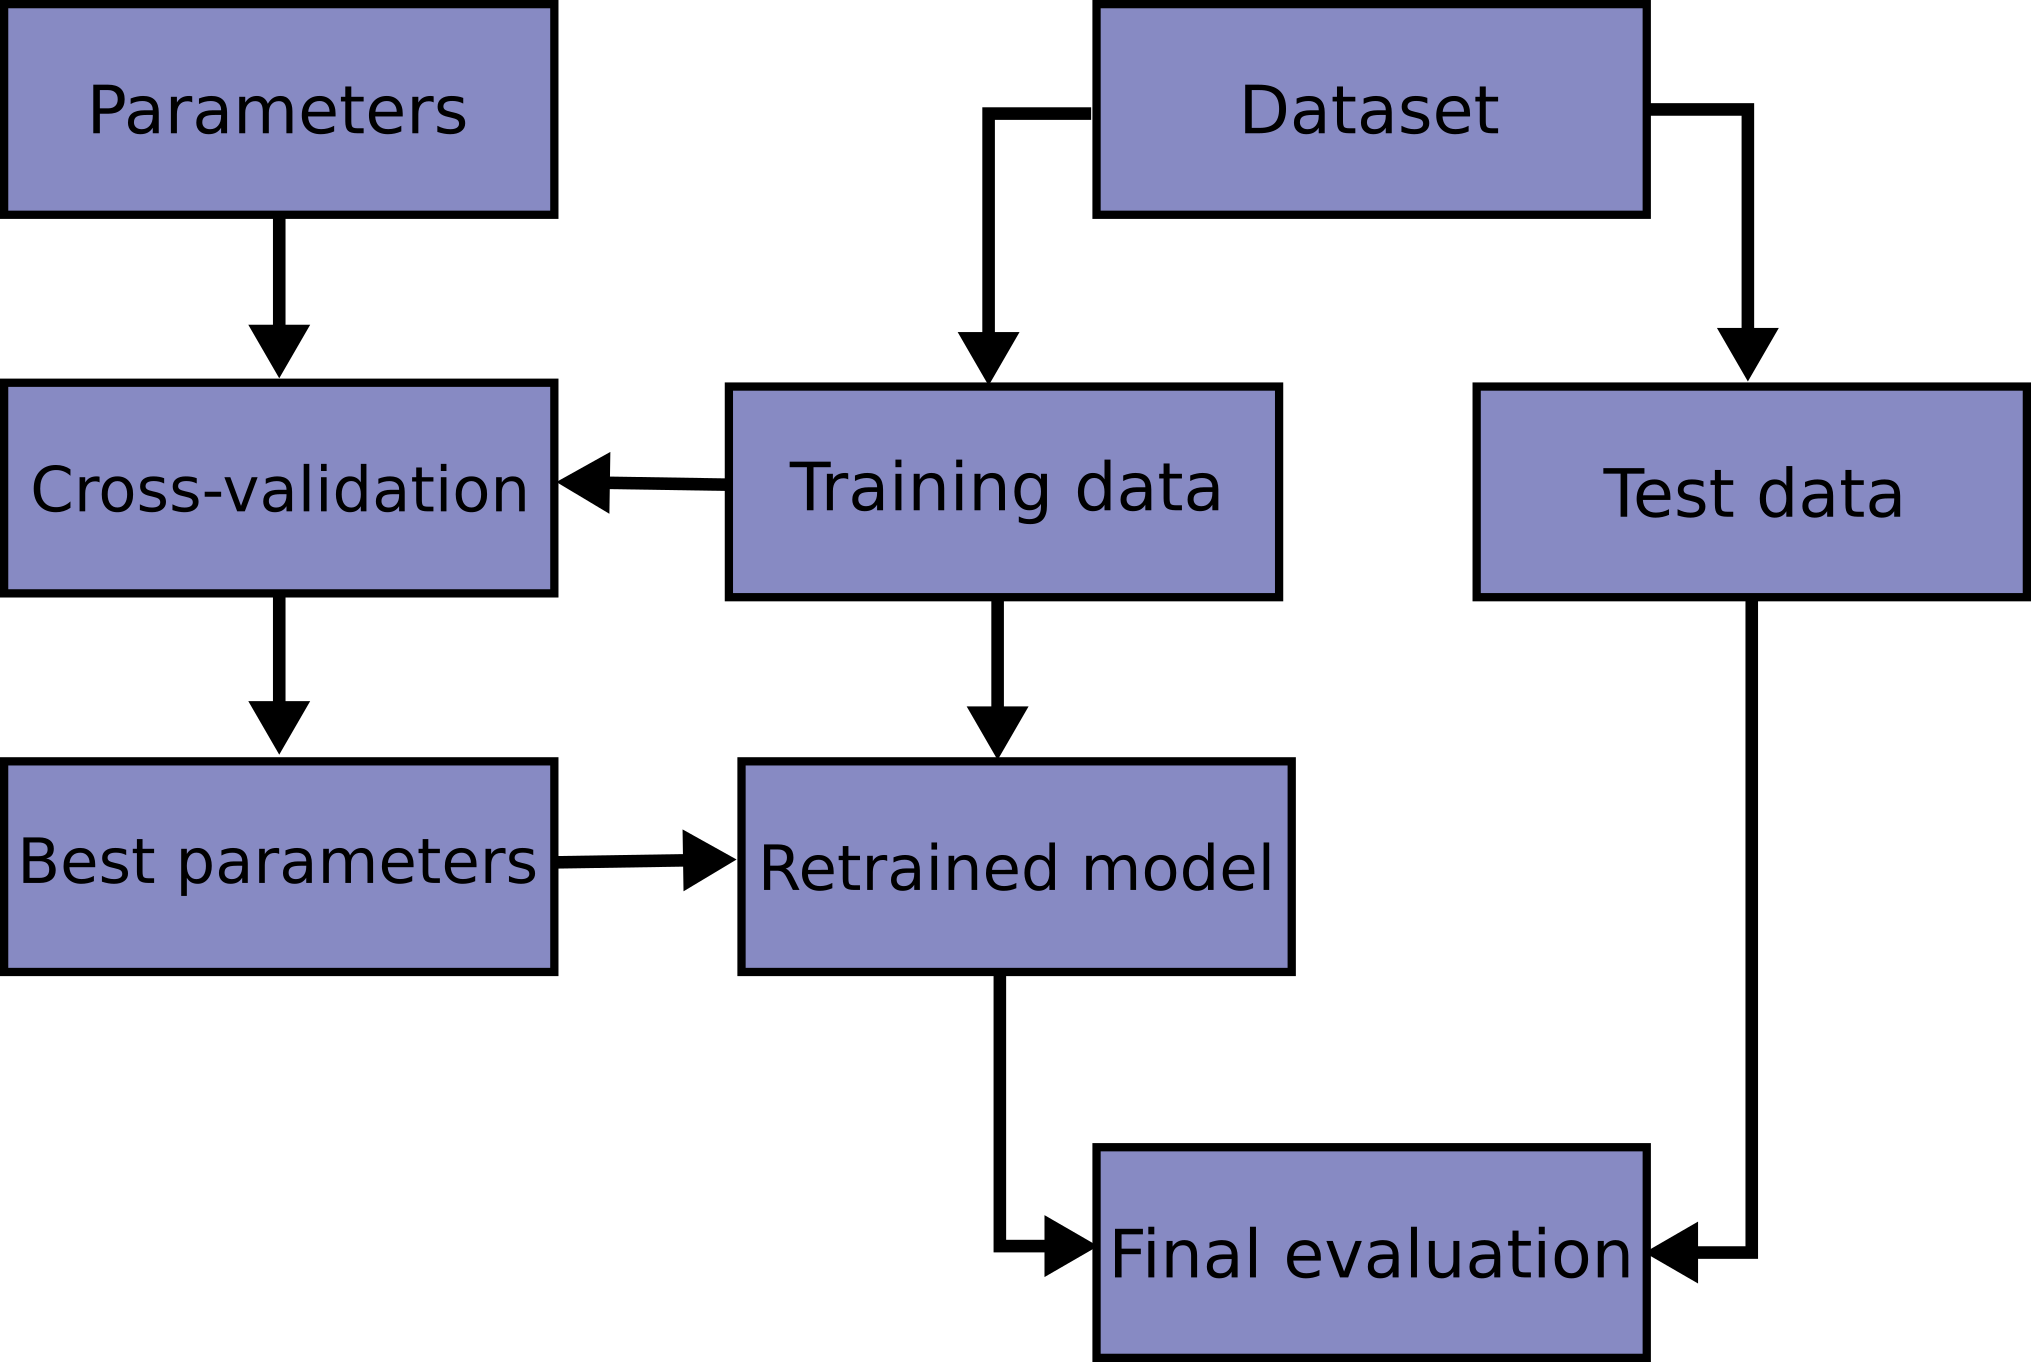

## Holdout method

* Partition the training data again: training set and validation set

* Use the validation part to estimate accuracy whenever needed

<div align="center">

</div>

**Pros:**
* Very efficient
* Fine with lots of data when losing a fraction is not a problem

**Cons:**
* Yet another part of data not used for training
* Problematic when the data set is small
* Testing part could contain important information

## $k$–fold cross–validation

* Partition the training set into $k$ folds at random
* Repeat $k$ times:
  - train on $k-1$ folds
  - estimate the accuracy on the $k$-th fold
* Return the mean


<div align="center">

</div>

**Pros:**
* Every data point used for training most of the time
* Less variance in the estimate

**Cons:**
* $k$ times slower

## LOOCV: Leave–one–out cross–validation

* Extreme case of the previous approach: separate fold for each data point


* For each data point $q$:
  - train on data without $q$
  - estimate the accuracy on $q$
* Return the mean of accuracies


**Cons:**
* Even more expensive

## Many other options

* Generalization: leave–$p$–out cross–validation enumerates over $\binom{n}{p}$ subsets

* Sampling instead of trying all options

* A variation that ensures that all classes evenly distributed in folds

* ... 



In [30]:
:dep linfa = {version = "0.7.0"}
:dep linfa-datasets = { version = "0.7.0", features = ["iris"] }
:dep linfa-trees = { version = "0.7.0" }
:dep ndarray = { version = "0.16.1" }
:dep ndarray-rand = {version = "0.15.0" }
:dep rand = { version = "0.8.5", features = ["small_rng"] }
:dep smartcore = { version = "0.3.2", features = ["datasets", "ndarray-bindings"] }

use linfa::prelude::*;
use linfa_trees::DecisionTree;
use ndarray_rand::rand::SeedableRng;
use rand::rngs::SmallRng;
use linfa_trees::DecisionTreeParams;

fn crossvalidate() -> Result<(), Box<dyn std::error::Error>> {
    let mut iris = linfa_datasets::iris();
    let mut rng = SmallRng::seed_from_u64(42);

    // Split the data into training and testing sets
    let (train, test) = iris.clone()
        .shuffle(&mut rng)
        .split_with_ratio(0.8);

    // Extract the features (X) and target (y) for training and testing sets
    let X_train = train.records();
    let y_train = train.targets();
    let X_test = test.records();
    let y_test = test.targets();

    // Print the shape of the training and testing sets
    println!("X_train shape: ({}, {})", X_train.nrows(), X_train.ncols());
    println!("y_train shape: ({})", y_train.len());
    println!("X_test shape: ({}, {})", X_test.nrows(), X_test.ncols());
    println!("y_test shape: ({})", y_test.len());

    // Train the model on the training data
    let model = DecisionTree::params()
        .max_depth(Some(3))
        .fit(&train)?;

    // Evaluate the model's accuracy on the training set
    let train_accuracy = model.predict(&train)
        .confusion_matrix(&train)?
        .accuracy();
    println!("Training accuracy: {:.2}%", train_accuracy * 100.0);

    // Evaluate the model's accuracy on the test set
    let test_accuracy = model.predict(&test)
        .confusion_matrix(&test)?
        .accuracy();
    println!("Test accuracy: {:.2}%", test_accuracy * 100.0);
    
    // Now let's see what the model shows when crossvalidating
    let dt_params1 = DecisionTree::params().max_depth(Some(3));
    let dt_params2 = DecisionTree::params().max_depth(Some(2));
    let models = vec![dt_params1, dt_params2];

    let scores = iris.cross_validate_single(5, &models, |prediction, truth|
        Ok(prediction.confusion_matrix(truth.to_owned())?.accuracy()))?;
    println!("Cross-validation scores: {:?}", scores);

    // Perform cross-validation using fold
    let scores: Vec<_> = iris.fold(5).into_iter().map(|(train, valid)| {
       let model = DecisionTree::params()
          .max_depth(Some(3))
          .fit(&train).unwrap();
       let accuracy = model.predict(&valid).confusion_matrix(&valid).unwrap().accuracy();
       accuracy
    }).collect();
    
    println!("Cross-validation scores general: {:?} {}", scores, scores.iter().sum::<f32>()/scores.len() as f32);

    Ok(())
}

crossvalidate();

X_train shape: (120, 4)
y_train shape: (120)
X_test shape: (30, 4)
y_test shape: (30)
Training accuracy: 96.67%
Test accuracy: 90.00%
Cross-validation scores: [0.93999994, 0.9133333], shape=[2], strides=[1], layout=CFcf (0xf), const ndim=1
Cross-validation scores general: [1.0, 1.0, 1.0, 0.93333334, 1.0] 0.9866667


# <font color="red">1. Styles of Parallel Programming <font>

# 2. Limits of Parallelism (Amdahl's law)

# 3. Examples of parallel programs


* Instruction level parallelism
  * Done at the hardware level.  CPU determines independent instructions and executes them in parallel! Often assisted by the compiler which arranges instruction so contiguous instructions can be executed concurrently.
* Thread level parallelism
  * Done at the software level.  Programmer or compiler decomposes program onto mostly independent parts and creates separate threads to execute them.
* Message passing between threads
  * When coordination or data exchange needs arise in #2 the coordination and or data exchange happens by explicitly sending messages between threads.
* Shared memory between threads
  * Threads share all the memory and use locks/barriers to coordinate between them (more below).
* Pipeline Parallelism
  * Output of one thread is input to another
* Data parallelism
  * Each thread works on a different part of the data
* Model parallelism (new)
  * Arose due to large ML models where each thread/core has a part of the model and updates its parameters

## How much memory in a NVDA A100 GPU?
* ### 80 Gbytes of high bandwidth memory  

## What is the size of GPT-4?
* ### 1.7 trillion parameters, 4 bytes each (?), ~6.8Tbytes?  So clearly it will not fit in a single GPU memory

# 1. Styles of Parallel Programming 

# <font color="red"> 2. Limits of Parallelism (Amdahl's law)<font>

# 3. Examples of parallel programs


Let an algorithm A have a serial S and a parallel P part.  Then the time to execute G is:
$$T_A = T_{SA} + T_{PA}$$
Running on multiple processors only affects $T_{PA}$

$$T_{A}(n) = T_{SA} + \frac{T_{PA}}{n}$$ which as ${n\to\infty}$ becomes $T_{A}(n) = T_{SA}$

So the maximum possible speedup for a program is $$\frac{T_{A}}{T_{SA}}$$

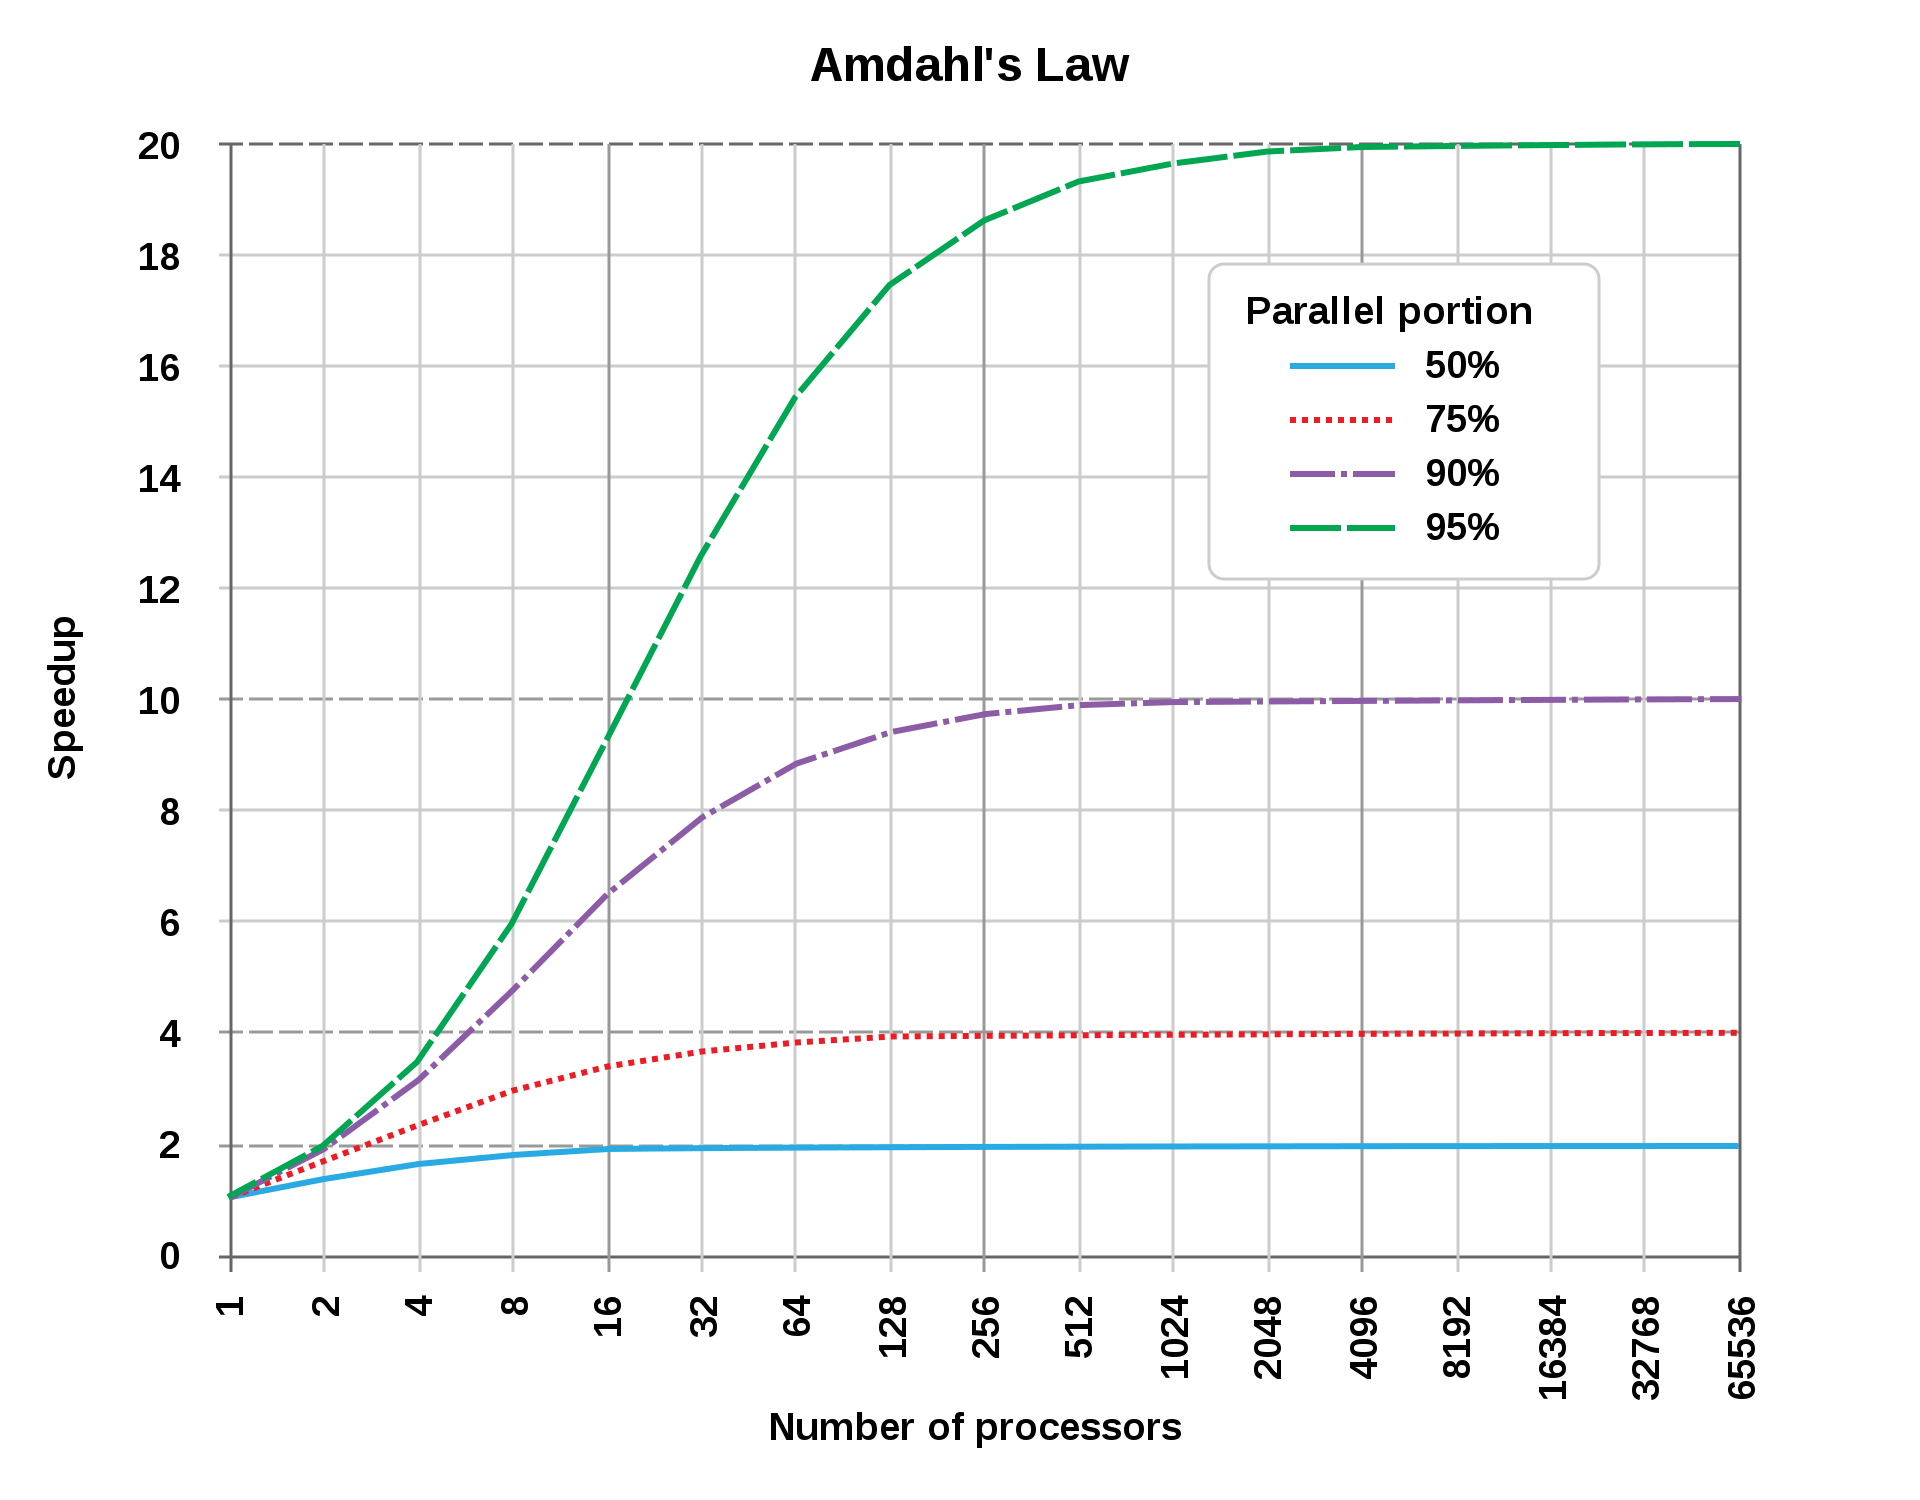

# 1. Styles of Parallel Programming 

# 2. Limits of Parallelism (Amdahl's law)

# <font color="red"> 3. Examples of parallel programs <font>


## Message passing between threads

In [4]:
use std::thread;
use std::sync::mpsc;
use std::time::Duration;


fn communicate(id:i32, tx: mpsc::Sender<String>, rx:mpsc::Receiver<&str>) {
   let t = format!("Hello from thread {}", id);
   tx.send(t).unwrap();
   let a:&str = rx.recv().unwrap();
   println!("Thread {} received {}", id, a);
}

fn main_thread() {

    let (tx1, rx1) = mpsc::channel();
    let (tx2, rx2) = mpsc::channel();
    // let handle1 = 
    let handle1 = thread::spawn(move || {
       communicate(1, tx1, rx2);
    });

    let (tx3, rx3) = mpsc::channel();
    let (tx4, rx4) = mpsc::channel();

    // let handle2 = 
    let handle2 = thread::spawn(move || {
       communicate(2, tx3, rx4);
    });

    let a:String = rx1.recv().unwrap();
    let b:String = rx3.recv().unwrap();
    println!("Main thread got \n{}\n{}\n\n", a, b);
    tx2.send("Hi from main").unwrap();
    tx4.send("Hi from main").unwrap();
    thread::sleep(Duration::from_millis(5000));
    handle1.join().unwrap();
    handle2.join().unwrap();
}

main_thread();

Main thread got 
Hello from thread 1
Hello from thread 2


Thread 1 received Hi from main
Thread 2 received Hi from main


## Sharing Memory using Exclusive Locks or Reader/Writer Locks (follow on terminal @16 @8K)

### Important data structures

* std::sync::Arc
* std::sync::Mutex
* std::sync::RwLock

## What if you want to write into your shared data structure?  It can be done as long as the written parts are separable (follow on terminal @16 @8K)

### Important data structures
* Vec.chunks_mut(chunk_size)
* rayon::scope.spawn()

## Put it all together Parallel Game of Life (follow on terminal use 2K matrix to see benefits)

## Try and take advantage of the builtin par_** methods for regular problems.  Gaussian elimination example (follow on terminal 1K matrix)

### Important data structures

* par_iter_mut()
* ThreadPoolBuilder()